# Final Project
Quinn Frank <br>
November 20, 2020

# Step 1: Generative Model

In [406]:
import nltk
nltk.download("tagsets")
nltk.download("brown")
# http://www.anc.org/software/anc-tool/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Quinn\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [490]:
train = nltk.corpus.brown.tagged_sents(tagset="universal")[:10000]
test = nltk.corpus.brown.tagged_sents(tagset="universal")[10000:12000]

## Problem 1

Below is a function which estimates the parameters of a Hidden Markov Model for part of speech tagging from a training set of tagged sentences.  The training set consists of 10,000 sentences tagged with the "universal" tagset.  Note the inclusion of an *\<UNK\>* token and the use add-$k$ smoothing (for a small $k$ value).  The set of all unique words in the training set is considered the "vocabulary" in this case, and as usual, case is ignored.

In [492]:
def separate_tagged_sents(tagged_sents):
    """Given a list of list of (token, TAG) pairs from Brown corpus,
       returns a parallel list of tokens and a list of tags."""
    
    # Combine the sentences together
    tagged_tokens = [pair for sent in tagged_sents for pair in sent]
    return tuple(map(list, zip(*tagged_tokens)))

In [493]:
def estimate_hmm(tagged_sents, tagset=None, vocab=None):
    """
    Estimates parameters of a Hidden Markov Model by MLE.  The vocabulary (size V)
    of words are the observations and the tags (size N) are the hidden states.
    Uses an OOV token and Laplace smoothing to avoid zero probabilities/likelihoods.
    
    ---Parameters---
    - tagged_sents: list of list of (token, TAG) pairs; each sublist represents one sentence
    - tagset: (N,) vector of unique tags to consider; inferred from data if None
    - vocab: (V,) vector of unique words to consider; inferred from data if None
    
    ---Returns---
    - A: (N, N) Markov transition matrix between states (rows sum to 1);
      entry i,j = Pr(state i -> state j)
    - B: (V+1, N) emission probability matrix; entry i,j = Pr(obs i | state j)
    - pi: (N,) initial distribution over the N states
    """
    
    tokens, tags = separate_tagged_sents(tagged_sents)
    assert len(tokens) == len(tags), "Observations and states must be same length."
    if tagset is None:
        tagset = sorted(set(tags))
    if vocab is None:
        vocab = sorted(set(map(str.lower, tokens)))
    vocab.append("<UNK>")   # add an "out of vocabulary" token
    
    # Begin with unnormalized count matrices
    A_counts = pd.DataFrame(0, dtype='int', index=tagset, columns=tagset)
    B_counts = pd.DataFrame(0, dtype='int', index=tagset, columns=vocab)
    pi_counts = pd.Series(0, dtype='int', index=tagset)
    
    # Loop over each (obs, state) pair, update corresponding counts
    for sent in tagged_sents:
        start_token, start_tag = sent[0]
        pi_counts[start_tag] += 1
        
        for i in range(len(sent)):
            this_token, this_tag = sent[i]
            B_counts.loc[this_tag, this_token.lower()] += 1
            
            # On the last token in the sentence, nothing follows, so don't update A
            if i != len(sent)-1:
                next_token, next_tag = sent[i+1]
                A_counts.loc[this_tag, next_tag] += 1
    
    # Apply add-k smoothing for everything (just add k to all counts, then marginalize)
    # Laplace is too extreme for this case, anecdotally
    smooth = 1e-4
    A = (A_counts + smooth) / np.sum(A_counts + smooth, axis=1)[:, None]
    B = (B_counts + smooth) / np.sum(B_counts + smooth, axis=1)[:, None]
    pi = (pi_counts + smooth) / np.sum(pi_counts + smooth)
    return A, B, pi

In [494]:
# Use pre-tagged sentences to develop HMM parameters
%time A, B, pi = estimate_hmm(train)

Wall time: 1min 34s


## Problem 2

Below is an implementation of the Viterbi algorithm for predicting hidden states from observations under a Hidden Markov Model.

In [495]:
def viterbi(obs, pi, A, B):
    """
    Implements the Viterbi dynamic programming algorithm to decode
    (i.e., assign parts of speech) to a series of observations.
    
    ---Parameters---
    - obs: a (T,) list of list of observations; stored as ints which index the vocabulary;
      each sublist is a sentence
    - pi, A, B: the initial state distribution, transmission probability matrix,
      and emission probability matrix produced by `estimate_hmm`
    
    ---Returns---
    - states: a (T,) list of list of inferred states; stored as ints which index the tagset;
      each sublist is a sentence
    """
    
    all_states = []
    # Convert pi, A, and B to ndarrays and convert to log space to avoid underflow
    pi = np.log(pi.to_numpy())
    A = np.log(A.to_numpy())
    B = np.log(B.to_numpy())    
    
    for sentence_obs in obs:
        viterbi = np.zeros((len(pi), len(sentence_obs)))     # probability matrix (also log space)
        backpointer = np.zeros(viterbi.shape, dtype='int')   # int entries encoding path's last location
    
        # Treat the initial state separately
        viterbi[:, 0] = pi + B[:, sentence_obs[0]]
        backpointer[:, 0] = -1
        #print(f"\n{pd.Series(viterbi[:, 0].round(2), index=tagset).sort_values()}")
        
        # Compute the Viterbi probs / backpointers dynamically, based only on previous column
        for t in range(1, len(sentence_obs)):
            for s in range(len(pi)):
                # Figure out the optimal path to state 's' at observation 't'
                path_likes = viterbi[:, t-1] + A[:, s] + B[s, sentence_obs[t]]
                viterbi[s, t] = np.max(path_likes)
                backpointer[s, t] = np.argmax(path_likes)
            #print(f"\n{pd.Series(viterbi[:, t].round(2), index=tagset).sort_values()}")
        
        # Final path is the max of last column - follow path back to get all states
        states = [np.argmax(viterbi[:, -1])]
        for t in range(1, len(sentence_obs))[::-1]:
            states.append(backpointer[states[-1], t])
        states = states[::-1]
        all_states.append(states)
    
    return all_states

## Problem 3

Below are some helper functions to convert lists of words and tags to index form, given a vocabulary and a set of tags being considered.  There is also a function to visualize the comparison between correct tagging and predicted tagging, to manually assess the effectiveness of the algorithm.

The test set consists of three unseen sentences from the Brown corpus, and as can be seen, the Viterbi algorithm is very successful in inferring the hidden parts of speech, even when the token is foreign to the original vocabulary.

In [496]:
def get_loc(index, entry, default):
    """Overloaded `get_loc` method from pd.Series.Index.
       If entry is in the `index`, returns the integer location.
       If not, returns the location of the default value (default must be in `index`)."""
    
    try:
        return index.get_loc(entry)
    except KeyError:
        return index.get_loc(default)

    
def index_tagged_sents(tagged_sents, tagset, vocab):
    """Given a list of list of (token, TAG) pairs from Brown corpus,
       returns a list of list of tokens and tags as indexes
       on the corresponding tagset and vocabulary."""
    
    tokens, tags = [], []
    
    for i, sentence in enumerate(tagged_sents):
        sub_tokens, sub_tags = tuple(map(list, zip(*sentence)))
        tags.append([get_loc(tagset, tag, "X") for tag in sub_tags])
        tokens.append([get_loc(vocab, token.lower(), "<UNK>") for token in sub_tokens])
        
    return tokens, tags

In [497]:
def visualize_tagging(token_idx, tag_idx, predict_tag_idx, vocab, tagset):
    """Creates a nicely-formatted printout comparing the correct part of speech
       tagging for a sentence with the HMM-predicted tags."""
    
    for i in range(len(token_idx)):
        df = pd.DataFrame({'correct': tagset[tag_idx[i]],
                           'predict': tagset[predict_tag_idx[i]]},
                          index = vocab[token_idx[i]])
        print(f"\n-----------------------------\n{df}")

In [498]:
tagset, vocab = B.index, B.columns
token_idx, tag_idx = index_tagged_sents(test, tagset, vocab)
%time predict_tag_idx = viterbi(token_idx, pi, A, B)

#visualize_tagging(token_idx, tag_idx, predict_tag_idx, vocab, tagset)

Wall time: 3.57 s


In [499]:
predict_array = np.array(sum(predict_tag_idx, []))
correct_array = np.array(sum(tag_idx, []))

In [500]:
np.mean(predict_array == correct_array)

0.9188078858448598

# Step 3: Discriminative Neural Network

In [501]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

from gensim.models import Word2Vec, FastText

In [502]:
# Train a FastText word embedder to convert words to 
untagged_train = nltk.corpus.brown.sents()
%time embedder = FastText(sentences=untagged_train)

Wall time: 23.6 s


In [564]:
# Helpers for processing and loading data

def get_loc(index, entry, default=None):
    """Overloaded `get_loc` method from pd.Series.Index.
       If entry is in the `index`, returns the integer location.
       If not, returns the location of the default value (default must be in `index`)."""
    
    try:
        return index.get_loc(entry)
    except KeyError:
        return index.get_loc(default)
    

def split_tagged_sents(tagged_sents):
    """Given an iterable of iterable of (token, POS) pairs,
       returns parallel iterable of iterables for tokens and POS.
       Keeps the underlying sentence structures."""
    
    untuple = lambda it: tuple(zip(*it))
    split_sents = tuple(map(untuple, tagged_sents))
    return untuple(split_sents)

In [586]:
class POSDataset(torch.utils.data.Dataset):
    """Custom Dataset class which digests an NLTK tagged dataset
       and converts sentences to torch tensors dynamically.
       
       > dataset = POSDataset(train, embedder, tagset)
       dataset[batch_idx] returns a tuple of the form:
       - tokens = float tensor of size (seq_len, batch_size, input_size)
         NOTE: if sequences are different lengths, the sequences which are too short
         will have padding along dim=2; dataset is sorted by sentence length to minimize this
       - tags = int tensor of size (seq_len, batch_size, 1)
       - mask = boolean tensor of size (seq_len * batch_size) indicating non-padded values
       
       Initialization parameters:
       - sentences = an iterable of iterable (token, POS) pairs
       - embedder = a TRAINED gensim embedder network like Word2Vec or FastText
       - tagset = an iterable of tags, in some fixed order"""
    
    def __init__(self, sentences, embedder, tagset):
        self.sentences = sentences
        self.embedder = embedder
        self.tagset = tagset
    
    def shuffle(self):
        # Shuffles around sentences, while keeping similar-length sentences together
        self.sentences = sorted(self.sentences,
                                key=lambda sent: (len(sent), np.random.random()))
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        these_sentences = self.sentences[index]
        # If an integer is passed in, this could break, need to wrap in another list
        if type(index) is int:
            print(these_sentences)
            these_sentences = [these_sentences]
            
        sent_list, tag_lists = split_tagged_sents(these_sentences)
        
        # Convert both the words and tags to numerical form
        embedded_list = [torch.tensor(embedder.wv[sent]) for sent in sent_list]
        label_list = [torch.tensor([get_loc(self.tagset, tag, "X") for tag in tag_list])
                      for tag_list in tag_lists]
        
        # If sequence lengths are difference,
        # pad the end of the embeddings and labels for the shorter sentences
        null_pad = get_loc(self.tagset, "X")
        X_pad = pad_sequence(embedded_list)
        y_pad = pad_sequence(label_list, padding_value=-1)
        
        # Find where the null-padded values are, so the loss function can ignore them
        mask = y_pad != -1
        y_pad[y_pad == -1] = null_pad
        
        return X_pad, y_pad, mask

In [587]:
class POSDataLoader():
    """Custom DataLoader-like object that works with POSDataset."""
    
    def __init__(self, dataset, batch_size, shuffle=True):
        assert type(dataset) is POSDataset, "Only supports POSDataset objects"
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    def __iter__(self):
        if self.shuffle: self.dataset.shuffle()
        return POSDataIterator(self.dataset, self.batch_size)
    

class POSDataIterator():
    """Iterator object which returns (X, y) pairs from a POSDataset of specified
       batch size until it reaches the end."""
    
    def __init__(self, dataset, batch_size):
        self.dataset = dataset
        self.batch_size = batch_size
        # Keep track of the pointer's location on the batch index
        self._idx = 0
        
    def __next__(self):
        # Returns the next (X, y) pair
        if self._idx >= len(self.dataset):
            raise StopIteration
        else:
            start_idx = self._idx
            end_idx = start_idx + self.batch_size
            self._idx = end_idx
            return self.dataset[start_idx:end_idx]

In [590]:
train_set = POSDataset(train, embedder, tagset)
test_set = POSDataset(test, embedder, tagset)
model = BLSTM(100, 128, 2, len(tagset))

X, y, mask = train_set[:10]
m = model(X)
print(X[:, 2, -1])
print(y[:, 2])
print(mask[:, 2])

tensor([ 1.3465,  0.4453,  0.4254,  0.4908,  0.6027, -0.2117,  0.6639, -0.3890,
         0.3149,  0.5346,  0.2132,  0.3900,  0.2749,  0.0533, -2.5285,  0.2451,
         0.6246,  0.6119,  0.4771, -2.1295,  0.5924,  1.9198, -0.4679,  0.1540,
         0.1471,  0.5693,  1.0573, -0.9300,  0.4143, -0.3890,  0.3184,  0.2762,
         0.7823,  0.1456, -2.4492,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000])
tensor([ 5,  6,  6,  6, 10, 10, 10,  2,  6,  1,  6,  6,  6,  6,  9, 10,  6,  2,
         1,  0,  6,  0,  2,  5,  1,  6,  5, 10, 10,  2,  6,  6,  6,  6,  0, 11,
        11, 11, 11, 11, 11, 11, 11])
tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False, False,
        False, False, False])


In [567]:
# Architecture
# https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1%20-%20BiLSTM%20for%20PoS%20Tagging.ipynb

class BLSTM(nn.Module):
    """Bidirectional, stacked LSTM RNN for sequence to sequence translation.
       Given a variable-length time-indexed sequence of word embeddings, produces a
       probability distribution over a finite tagset, for supervised learning.
       
       input shape:  (seq_len, batch_size, input_size),
       output shape: (seq_len, batch_size, output_size), softmax along dim=2"""
    
    def __init__(self, embed_size, hidden_size, num_layers, output_size):
        super(BLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=embed_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=True,
                            dropout=0.25)
        self.classify = nn.Sequential(nn.Linear(2 * hidden_size, output_size),
                                      nn.Dropout(0.25))
        
    def forward(self, X):
        output, (h, c) = self.lstm(X)
        return self.classify(output)
    
    def predict(self, X):
        """Once model is TRAINED, call to predict y labels on input.
           
           input shape: (seq_len, batch_size, input_size),
           output shape: (seq_len, batch_size)"""
        
        return torch.argmax(self.forward(X), dim=2)

In [676]:
# Training function

def train_BLSTM(model, train_set, test_set,
                num_epochs=100, batch_size=16,
                use_cuda=True, train_summ=None, print_every=1):
    """Trains a BLSTM model for some fixed number of epochs.
       Loads data in batches, shuffling after each full epoch
       (if sentence lengths are difference, post-padding is added and ignored in loss calculation).
       Prints logs of train/test accuracy after each epoch and returns
       plottable dictionary of training results.
       
       Parameters
       - num_epochs: the number of epochs over train_set
       - batch_size: how many sentences from train_set to run before updating weights
                     (if sentence lengths are uneven, padding occurs at the end)
       - train_summ: summary dictionary produced by previous function call;
                     use to continue training while maintaining previous history
       - print_every: how often loss function statistics should be printed, in epochs
    """
    
    # Move to GPU if possible; batches get moved as needed to save on memory
    device = "cuda:0" if use_cuda and torch.cuda.is_available() else "cpu"
    
    # model(X) and y come out as 3d tensors
    # Need to combine seq_len and batch_size along dim=0 to calculate loss
    flatten = nn.Flatten(0, 1)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.8)
    
    # Initialize a dictionary summarizing training, if one not provided
    if train_summ is None:
        train_summ = {'loss': [],        # one per batch
                      'train_acc': [],   # one per epoch
                      'test_acc': [],    # one per epoch
                      'num_epochs': num_epochs}
    else: train_summ['num_epochs'] += num_epochs
    
    train_loader = POSDataLoader(train_set, batch_size, shuffle=True)
    test_loader = POSDataLoader(test_set, batch_size)
    
    for epoch in range(num_epochs):
        # Only let the model be in training mode in this block
        model.train()
        
        for X, y, mask in train_loader:
            X = X.clone().to(device)
            y = y.clone().to(device)
            
            optimizer.zero_grad()
            
            # Apply a Boolean mask to ignore the post-padding values
            # This also flattens to (N, #classes) format for CrossEntropyLoss
            #print(sum(mask))
            loss = criterion(model(X)[mask, :], y[mask])
            loss.backward()
            optimizer.step()
            train_summ['loss'].append(loss.detach().cpu().item())
        
        # Evaluate how the model is performing on the entire training/testing sets
        train_acc, test_acc = eval_BLSTM(model, train_loader, test_loader, device)  
        train_summ['train_acc'].append(train_acc)
        train_summ['test_acc'].append(test_acc)
        
        if (epoch+1) % print_every == 0:
            print(f"- EPOCH {epoch+1}:" + 
                  f"\n  train loss = {train_summ['loss'][-1]}" +
                  f"\n  accuracy   = " +
                  f"{round(train_acc, 4)} (train) / {round(test_acc, 4)} (test)" +
                  "\n----------------------------")
    
    assert not model.training
    return train_summ


def eval_BLSTM(model, train_loader, test_loader, device):
    """Evaluates model on provided training and testing set.
       Due to memory limits, must take in data loaders and predict in batches.
       Returns float values (train_acc, test_acc)"""
    
    # Set the model to evaluation mode to ignore non-deterministic effects like dropout
    model.eval()
    train_checks, test_checks = [], []
    
    # Train predict
    for X, y, mask in train_loader:
        X = X.clone().to(device)
        y = y.clone().to(device)
        y_predict = model.predict(X)
        train_checks.append(y[mask] == y_predict[mask])
    train_checks = torch.cat(train_checks).float()
    train_acc = torch.mean(train_checks).cpu().item()
    
    # Test predict
    for X, y, mask in test_loader:
        X = X.clone().to(device)
        y = y.clone().to(device)
        y_predict = model.predict(X)
        test_checks.append(y[mask] == y_predict[mask])
    test_checks = torch.cat(test_checks).float()
    test_acc = torch.mean(test_checks).cpu().item()
    
    return train_acc, test_acc

In [677]:
# Plotting training summaries

def plot_train_summ(train_summ):
    """Produces plots that summarize and compare training of a model.
       Input should be a dictionary of the form:
       {loss: [...],
        train_acc: [...], test_acc: [...],
        num_epochs: ### } (dict returned by train_*) }"""
     
    fig, ax = plt.subplots(figsize=(10, 5))
    epochs = np.linspace(0, train_summ['num_epochs'], len(train_summ['loss']))
    ax.plot(epochs, train_summ['loss'], label="train")
    ax.legend()
    ax.set_title(f"Training Curve for BLSTM")
    ax.set_xlabel("epoch number")
    ax.set_ylabel("cross-entropy loss")
    plt.show()
    
    fig, ax = plt.subplots(figsize=(10, 5))
    epochs = range(train_summ['num_epochs'])
    for dataset in ["train", "test"]:
        ax.plot(epochs, train_summ[f'{dataset}_acc'], label=dataset)
    ax.legend()
    ax.set_title(f"Classification Accuracy for BLSTM")
    ax.set_xlabel("epoch number")
    ax.set_ylabel("accuracy")
    ax.legend()
    plt.show()

In [678]:
train_set = POSDataset(train, embedder, tagset)
test_set = POSDataset(test, embedder, tagset)
model = BLSTM(100, 128, 2, len(tagset)).cuda()

%time summ = train_BLSTM(model, train_set, test_set, \
                         num_epochs=20, batch_size=16, use_cuda=True)

- EPOCH 1:
  train loss = 1.5224891901016235
  accuracy   = 0.6416 (train) / 0.6148 (test)
----------------------------
- EPOCH 2:
  train loss = 1.1185251474380493
  accuracy   = 0.742 (train) / 0.7211 (test)
----------------------------
- EPOCH 3:
  train loss = 0.9569438099861145
  accuracy   = 0.8153 (train) / 0.7989 (test)
----------------------------
- EPOCH 4:
  train loss = 0.8266292214393616
  accuracy   = 0.8466 (train) / 0.8355 (test)
----------------------------
- EPOCH 5:
  train loss = 0.7875801920890808
  accuracy   = 0.8644 (train) / 0.8545 (test)
----------------------------
- EPOCH 6:
  train loss = 0.7232800722122192
  accuracy   = 0.8775 (train) / 0.869 (test)
----------------------------
- EPOCH 7:
  train loss = 0.7051041722297668
  accuracy   = 0.8878 (train) / 0.8814 (test)
----------------------------
- EPOCH 8:
  train loss = 0.6757974624633789
  accuracy   = 0.8964 (train) / 0.8906 (test)
----------------------------
- EPOCH 9:
  train loss = 0.63731169700622

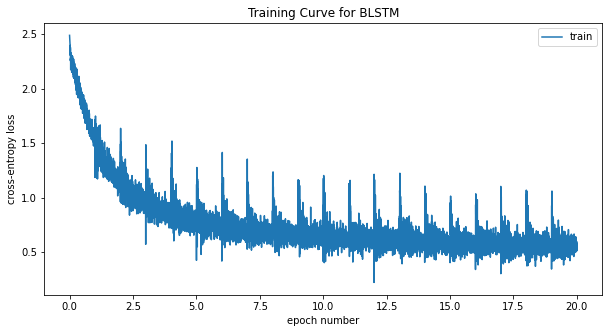

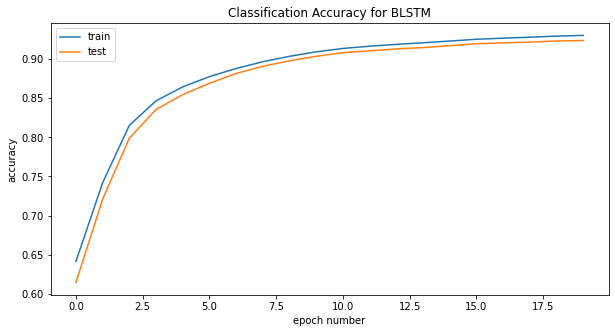

In [679]:
plot_train_summ(summ)

In [655]:
model.cpu()
X, y, mask = test_set[:10]
print(model.predict(X)[mask])
print(y[mask])

tensor([ 5,  6, 10,  0,  5,  6, 10,  2,  2,  2,  6,  0,  5,  0,  5,  0, 10,  6,
         5,  2,  2,  6, 10,  2,  6,  5, 10,  0, 10,  5,  5,  6,  5,  5, 10,  6,
        10,  5,  5,  6,  6,  0,  6,  6,  5,  6,  6,  6,  6,  0, 10, 10,  6,  6,
         6,  2,  6,  6,  6,  5, 10, 10,  0, 10,  6,  5,  0,  2,  2,  6, 10, 10,
         0, 10,  2,  6, 10,  6,  6,  6, 10, 10,  0,  2,  5,  6, 10,  6,  2,  6,
         2,  2,  0,  5,  5, 10, 10,  0,  5,  6,  5,  5,  6,  6,  6, 10, 10,  2,
         6,  2,  6,  5,  5,  6,  2, 10,  2,  5,  6,  6,  6,  5,  6,  2,  5,  5,
        10,  6,  6,  6,  6,  6,  6,  2,  6,  6,  5,  6,  6,  6,  2,  6,  0,  2,
         0,  6,  6,  0,  0,  6,  5,  2,  5,  5,  2,  6,  2, 10,  5,  0,  6,  5,
         6,  6,  5,  6,  6, 10,  5,  6,  6,  6,  6,  0,  5,  6,  6, 10,  6,  0,
         6,  6,  2,  2,  5,  6,  6, 10,  6,  6,  5,  0,  5,  2,  6,  2,  0, 10,
         2,  0,  6,  6,  5,  6,  5,  2,  2,  5,  2,  6,  6,  2,  6,  6,  2,  5,
         6,  6,  2,  2,  5,  6,  6,  2, 

In [630]:
print(model.predict(test_set[1001][0]))
print(test_set[1001][1])

[('Van', 'NOUN'), ('Varner', 'NOUN'), ('recently', 'ADV'), ('returned', 'VERB'), ('from', 'ADP'), ('Russia', 'NOUN'), ('.', '.')]
tensor([[ 1],
        [ 6],
        [ 3],
        [10],
        [ 2],
        [ 6],
        [ 0]])
[('Van', 'NOUN'), ('Varner', 'NOUN'), ('recently', 'ADV'), ('returned', 'VERB'), ('from', 'ADP'), ('Russia', 'NOUN'), ('.', '.')]
tensor([[ 6],
        [ 6],
        [ 3],
        [10],
        [ 2],
        [ 6],
        [ 0]])


In [621]:
print(model.predict(train_set[:20][0]).flatten()[10:])
print(train_set[:20][1].flatten()[10:])

tensor([0, 6, 6, 0, 0, 6, 6, 0, 0, 6])
tensor([0, 1, 6, 0, 0, 6, 6, 0, 0, 6])
